Workload = 50/50

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import ttest_ind
import statsmodels.stats.power as smp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

We load the datasets and extract only the relavant columns that we decided upon in 1st part of this project.


All cells until Pipeline cell are just adjusted Phase Two cells and so they can be ignored

In [28]:
df_processes=pd.read_csv("data/processes.csv",sep='\t')
df_connections = pd.read_csv("data/connections.csv", sep='\t')
df_connections=df_connections[df_connections.columns[:8]]
df_processes=df_processes[['imei','ts','mwra','p.android.gm','p.android.settings','p.system','p.android.externalstorage','p.android.documentsui']]
df_connections['ts']=pd.to_datetime(df_connections['ts'])
df_processes['ts']=pd.to_datetime(df_processes['ts'])
df = df_connections.merge(df_processes, on=['imei', 'ts','mwra'], how='inner')
df=df.drop('ts',axis=1)
df.head()
df.shape

(15495, 12)

We split the data into 2 dataframes in ratio o 8/2 ( standart data spliting ratios )

In [29]:

df, df_test= train_test_split(df, test_size=0.2, random_state=42)
print(df.shape,df_test.shape)
df_copy=df.copy()

(12396, 12) (3099, 12)


In [30]:
from sklearn.preprocessing import FunctionTransformer
plt.figure(figsize=(25,10))

drop_duplicates_transformer = FunctionTransformer(lambda X: X.drop_duplicates().reset_index(drop=True))

df = drop_duplicates_transformer.fit_transform(df)

#plt.subplot(1,2,1)
#sns.heatmap(df.iloc[:,2:].corr().round(decimals=2),annot=True)


<Figure size 2500x1000 with 0 Axes>

for loop will iterate over every column and remove_outlier function will with help of identify_outlier then remove the outlier of said column by replacing it with its nearest quantile . --note : added Class for pipeline

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return (a > upper) | (a < lower)

def remove_outlier(df,column):
    outlier_mask = identify_outliers(df[column])
    lower_bound = df[column].quantile(0.05)
    upper_bound = df[column].quantile(0.95)
    df.loc[outlier_mask, column] = np.where(
        df.loc[outlier_mask, column] < lower_bound,
        lower_bound,
        upper_bound
    )
    return df
#making it into class for pipelline
class RemoveOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for column in self.columns:
            X = remove_outlier(X, column) 
        return X

outlier_columns= df.columns.tolist()
remover_object=RemoveOutliers(outlier_columns)
df=remover_object.fit_transform(df)
df.describe()

,imei,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,1.199800e+04,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000
mean,3.914414e+18,0.624521,12.153148,12.749264,12.193128,12.097895,11.562253,12.215960,13.375488,13.299020,13.399578,13.903558
std,3.335746e+18,0.484267,2.590338,2.665492,2.400955,2.701516,2.325575,2.410926,2.571307,2.758768,2.433125,2.431975
min,3.590434e+17,0.000000,4.789020,4.991870,5.331430,4.622840,5.131260,5.301570,6.402280,5.382750,6.662700,7.203720
25%,8.630331e+17,0.000000,10.294835,10.810198,10.420678,10.175967,9.918465,10.449245,11.688000,11.315442,11.762245,12.215837
50%,3.590434e+18,1.000000,12.044580,12.855155,11.989820,11.938405,11.429915,11.987670,13.656610,13.318810,13.685635,13.999380
75%,8.630331e+18,1.000000,13.989657,14.711738,14.000765,13.907210,13.131283,13.959362,15.213907,15.288312,15.168892,15.611322
max,8.630331e+18,1.000000,19.514050,20.560460,19.332310,19.470180,17.935690,19.187440,20.431470,21.192750,20.251320,20.681910


Next we want to Scale the data . 

We decided on using RobustScaler because it uses median and IQR, also because it's less affected by skewness and is very reliable in producing stable scaled output.

Since we were tasked with using 2 scalers we decided on using MinMaxScaler because it can produce pretty much same result as RobustScaler making it more readable for humans and machines.



In here we created scale_data function that takes as arguments the dataframe , high_std_columns and low_std_columns . We didn't know how to choose which data to pick for which scaler that's why we decided to use std as value that decides. columns with std higher than 2.5 will be scaled by RobustScaler and columns with std bigger than 1 but lower than 2.5 will be scaled by MinMaxScaler to value bettwen 0 and 2 . In the function we first save the the mwra column to it's own variable and drop it from main df because it would cause problems in ColumnTransformer and shift the column values around. Next we create ColumnTransformer which has MinMaxScaler and RobustScaler inside of it where MinMaxScaler takes as argument low_std and RobustScaler takes high_std. Pipeline is then created and then the data is passed into the pipeline to scale the data and lastly we add the mwra back inside  --note : I decided to scale both dataframes for pipeline reasons


In [32]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
def scale_data(df, high_std_columns, low_std_columns):
    mwra = df[['imei','mwra']]
    df_transformed = df.drop(columns=[  'imei', 'mwra'], errors='ignore')


    # Define transformers for low and high std columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('low_std', MinMaxScaler(feature_range=(-2, 2)), low_std_columns),
            ('high_std', RobustScaler(), high_std_columns)
        ],
        remainder='passthrough'
    )
    
    # Create a pipeline with the ColumnTransformer
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    scaled_df = pipeline.fit_transform(df_transformed)
    scaled_df = pd.DataFrame(scaled_df, columns=df_transformed.columns)
    
    for column in scaled_df.columns:
        min_value = scaled_df[column].min()
        scaled_df[column] += abs(min_value) 
    

    final_df = pd.concat([mwra.reset_index(drop=True), scaled_df.reset_index(drop=True)], axis=1)
    return final_df[df.columns]
class ScaleData(BaseEstimator, TransformerMixin):
    def __init__(self, high_std_columns, low_std_columns):
        self.high_std_columns = high_std_columns
        self.low_std_columns = low_std_columns
    
    def fit(self, X, y=None):
        return self  # No fitting needed for scaling
    
    def transform(self, X, y=None):
        # Use the existing scale_data function to transform the data
        return scale_data(X, self.high_std_columns, self.low_std_columns)
# we devide the tables 
std_devs = df.drop(['imei','mwra'],axis=1).std()
high_std_columns = std_devs[std_devs > 2.5].index
low_std_columns = std_devs[(std_devs > 1) & (std_devs <= 2.5)].index
#we save this distribution and use it later for testing data as well
print("columns with std lower than 2.5 = "+low_std_columns)
print("columns with std higher than 2.5 = "+high_std_columns)
scale_transformer_connections = ScaleData(high_std_columns, low_std_columns)
df= scale_transformer_connections.fit_transform(df)




Index(['columns with std lower than 2.5 = c.katana',
       'columns with std lower than 2.5 = c.android.chrome',
       'columns with std lower than 2.5 = p.android.gm',
       'columns with std lower than 2.5 = p.android.externalstorage',
       'columns with std lower than 2.5 = p.android.documentsui'],
      dtype='object')
Index(['columns with std higher than 2.5 = c.dogalize',
       'columns with std higher than 2.5 = c.android.youtube',
       'columns with std higher than 2.5 = c.android.gm',
       'columns with std higher than 2.5 = p.android.settings',
       'columns with std higher than 2.5 = p.system'],
      dtype='object')


As can be observed, the values are all in range -2 to 2 

In [33]:
df.describe()

,imei,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,1.199800e+04,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000
mean,3.914414e+18,0.624521,1.960362,2.008990,1.991777,1.983094,1.988349,1.993094,1.988290,2.003369,1.977706,1.992582
std,3.335746e+18,0.484267,0.685944,0.726491,0.694498,0.716224,0.721751,0.701072,0.683190,0.724026,0.729261,0.694402
min,3.590434e+17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.630331e+17,0.000000,1.453979,1.495484,1.482853,1.501122,1.487475,1.490143,1.491290,1.488278,1.499109,1.493301
50%,3.590434e+18,1.000000,1.902278,1.967649,1.926015,2.067299,2.016787,1.963710,2.015431,1.960624,2.057436,1.997563
75%,8.630331e+18,1.000000,2.476797,2.499142,2.493986,2.503917,2.495173,2.490143,2.491290,2.488278,2.499109,2.493301
max,8.630331e+18,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.985315,3.990370,3.979195,3.978888,3.979491


In [34]:
#df.hist(column=df.columns[2:],figsize=(12,8))

Next we decided upon using PowerTransformer and QuantileTransformer but first we display data to better observe how the data is changing

In [35]:
df.describe()

,imei,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,1.199800e+04,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000
mean,3.914414e+18,0.624521,1.960362,2.008990,1.991777,1.983094,1.988349,1.993094,1.988290,2.003369,1.977706,1.992582
std,3.335746e+18,0.484267,0.685944,0.726491,0.694498,0.716224,0.721751,0.701072,0.683190,0.724026,0.729261,0.694402
min,3.590434e+17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.630331e+17,0.000000,1.453979,1.495484,1.482853,1.501122,1.487475,1.490143,1.491290,1.488278,1.499109,1.493301
50%,3.590434e+18,1.000000,1.902278,1.967649,1.926015,2.067299,2.016787,1.963710,2.015431,1.960624,2.057436,1.997563
75%,8.630331e+18,1.000000,2.476797,2.499142,2.493986,2.503917,2.495173,2.490143,2.491290,2.488278,2.499109,2.493301
max,8.630331e+18,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.985315,3.990370,3.979195,3.978888,3.979491


We decided to use PowerTransformer or QuantileTransformer for this task because as we were taught , the normal distribution is helpful in more than few aspects hence achieving gausian like distribution was our goal for this Machine Learning project.


Firstly we devided the data in same way as we did with df_connections . Then by creating function we achived abstraction and reusability for future use . In this function we once again save mwra to it's own column and transform the data using PowerTransformer and QuantileTransformer inside Pipeline . Lastly we concat the data and return them in same order as they were given to us (return final_df[df_processes.columns])


In [36]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer# type: ignore
from sklearn.base import BaseEstimator, TransformerMixin
#we make it into a function for better reusability
def transform_data(df,high_std_columns,low_std_columns):

    mwra = df[['imei','mwra']]
    df_transformed = df.drop(columns=['imei','mwra'])
    #column transformer for specified Transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('low_std', PowerTransformer(method='yeo-johnson'), low_std_columns),
            ('high_std', QuantileTransformer(output_distribution='normal'), high_std_columns)
        ],
        remainder='passthrough'
    )

    #  Create a pipeline with the ColumnTransformer
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    transformed_data = pipeline.fit_transform(df_transformed)
    transformed_df = pd.DataFrame(transformed_data, columns=df_transformed.columns)# convert the data back to df

    #  add 'mwra' back to the front
    final_df = pd.concat([mwra.reset_index(drop=True), transformed_df.reset_index(drop=True)], axis=1)

    # put them back to their original order
    return final_df[df.columns]
class TransformData(BaseEstimator, TransformerMixin):
    def __init__(self, high_std_columns, low_std_columns):
        self.high_std_columns = high_std_columns
        self.low_std_columns = low_std_columns
    
    def fit(self, X, y=None):
        return self  # No fitting needed for transformation
    
    def transform(self, X, y=None):
        # Use the existing transform_data function to transform the data
        return transform_data(X, self.high_std_columns, self.low_std_columns)
transformer_processes = TransformData(high_std_columns, low_std_columns)

df = transformer_processes.fit_transform(df)

#df.hist(column=df.columns[2:],figsize=(12,8))


Clear differences and better , more gausian like results can be observed

2.3 we can easily adjust the testing data using the exact same functions /methods we used on the training data (drop duplicats,remove_outlier,scale_data/transform_data). Pipeline was used in scale_data and transform_data

In [37]:
df_copy.shape

(12396, 12)

In [38]:

df.describe()

,imei,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,1.199800e+04,11998.000000,1.199800e+04,1.199800e+04,1.199800e+04,1.199800e+04,1.199800e+04,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000
mean,3.914414e+18,0.624521,2.946283e-16,-1.622676e-16,2.978855e-16,2.487314e-17,2.465106e-17,-0.007562,-0.000742,-0.004052,0.001509,0.001899
std,3.335746e+18,0.484267,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.002305,0.998951,1.003930,1.001851,1.000637
min,3.590434e+17,0.000000,-3.319711e+00,-2.684465e+00,-3.118867e+00,-2.381401e+00,-2.869911e+00,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,8.630331e+17,0.000000,-7.113398e-01,-7.002603e-01,-7.014851e-01,-6.999160e-01,-7.190175e-01,-0.685409,-0.678235,-0.681856,-0.671155,-0.675313
50%,3.590434e+18,1.000000,-5.325739e-02,3.061479e-02,-1.430787e-02,6.027889e-02,7.206162e-03,-0.008462,0.001028,-0.005143,0.003956,0.000633
75%,8.630331e+18,1.000000,7.409804e-01,6.991568e-01,7.205317e-01,7.032961e-01,7.211210e-01,0.665701,0.670550,0.672689,0.669939,0.682189
max,8.630331e+18,1.000000,2.653437e+00,2.841734e+00,2.683091e+00,3.090471e+00,2.861237e+00,5.199338,5.199338,5.199338,5.199338,5.199338


In [39]:
    
def create_pipeline(high_std_columns, low_std_columns, outlier_columns):
    return Pipeline(steps=[
        ('drop_duplicates', drop_duplicates_transformer),
        ('remove_outliers', RemoveOutliers(columns=outlier_columns)),
        ('scale_data', ScaleData(high_std_columns=high_std_columns, low_std_columns=low_std_columns)),
        ('transform_data', TransformData(high_std_columns=high_std_columns, low_std_columns=low_std_columns)),
    ])

pipeline = create_pipeline(high_std_columns, low_std_columns, outlier_columns)

df_transformed = pipeline.fit_transform(df_copy)
df_test_transformed = pipeline.transform(df_test)

df_transformed.describe()


,imei,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,1.199800e+04,11998.000000,1.199800e+04,1.199800e+04,1.199800e+04,1.199800e+04,1.199800e+04,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000
mean,3.914414e+18,0.624521,2.946283e-16,-1.622676e-16,2.978855e-16,2.487314e-17,2.465106e-17,0.002568,-0.002597,-0.004613,-0.004333,-0.002641
std,3.335746e+18,0.484267,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.003129,1.006443,1.010734,0.999598,1.002767
min,3.590434e+17,0.000000,-3.319711e+00,-2.684465e+00,-3.118867e+00,-2.381401e+00,-2.869911e+00,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,8.630331e+17,0.000000,-7.113398e-01,-7.002603e-01,-7.014851e-01,-6.999160e-01,-7.190175e-01,-0.674646,-0.678590,-0.682259,-0.683686,-0.679263
50%,3.590434e+18,1.000000,-5.325739e-02,3.061479e-02,-1.430787e-02,6.027889e-02,7.206162e-03,0.008997,0.002092,-0.005832,-0.005723,-0.002073
75%,8.630331e+18,1.000000,7.409804e-01,6.991568e-01,7.205317e-01,7.032961e-01,7.211210e-01,0.674222,0.676298,0.678887,0.670905,0.673038
max,8.630331e+18,1.000000,2.653437e+00,2.841734e+00,2.683091e+00,3.090471e+00,2.861237e+00,5.199338,5.199338,5.199338,5.199338,5.199338


In [40]:
df_transformed.head()

,imei,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
0,8630330696303481487,1.0,-1.597090,-0.128684,-0.001641,-2.201795,0.806672,-2.024029,-0.285461,-1.894629,-0.195378,-0.393094
1,8630330696303481818,1.0,0.035179,0.607123,0.092919,0.026788,0.648161,-0.690607,0.526959,-0.132907,1.363583,0.521356
2,8630330696303481305,1.0,1.215485,-0.769579,1.468727,0.630911,1.914650,0.141922,0.040842,-0.876029,-1.244042,-0.418600
3,3590433799317661602,1.0,-0.936825,-0.609458,0.850961,-0.546011,0.786641,-1.448650,0.576260,-1.731086,-0.458768,-0.194890
4,3590433799317661875,0.0,1.505521,-0.873810,-1.926143,0.928736,1.156259,1.659093,-1.664082,-1.399102,1.054594,-1.809272


Pipeline works !

Phase 3

3.1)A

Implementing ID3 classifier with maxdepth of 2 for better visualization

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score


X = df_transformed.drop(columns=['mwra']) 
y = df_transformed['mwra'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

id3_clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)

id3_clf.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)

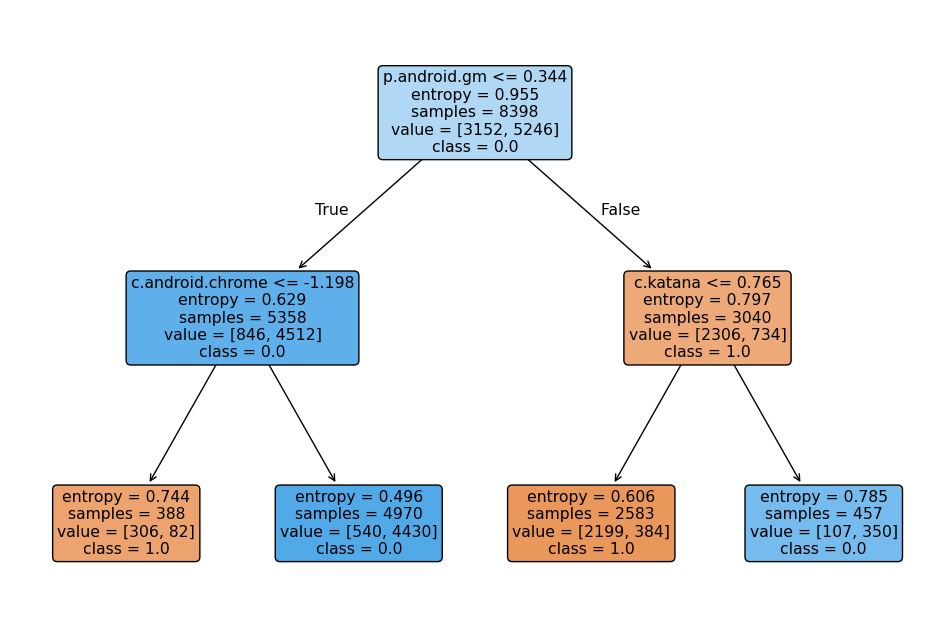

In [42]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# convert it bcs otherwise plot tree will complain
class_names = [str(cls) for cls in y.unique()]
plt.figure(figsize=(12, 8))
plot_tree(id3_clf, filled=True, feature_names=X.columns, class_names=class_names, rounded=True)
plt.show()


Training accuracy

In [43]:

y_train_pred_id3 = id3_clf.predict(X_train)
accuracy_train_id3=accuracy_score(y_train, y_train_pred_id3)
print("accuracy:", accuracy_train_id3)
print("recall score",recall_score(y_train, y_train_pred_id3, average='binary'))
print("precision:",precision_score(y_train, y_train_pred_id3, average='binary'))
print("classification:\n", classification_report(y_train, y_train_pred_id3))

accuracy: 0.8674684448678257
recall score 0.9111704155547083
precision: 0.880781278791229
classification:
               precision    recall  f1-score   support

         0.0       0.84      0.79      0.82      3152
         1.0       0.88      0.91      0.90      5246

    accuracy                           0.87      8398
   macro avg       0.86      0.85      0.86      8398
weighted avg       0.87      0.87      0.87      8398



Test accuracy

In [44]:

y_pred_id3 = id3_clf.predict(X_test)
id3_accuracy_test=accuracy_score(y_test, y_pred_id3)
id3_recall=recall_score(y_test, y_pred_id3, average='binary')
id3_precision=precision_score(y_test, y_pred_id3, average='binary')
print("accuracy:", id3_accuracy_test)
print("recall score",id3_recall)
print("precision:",id3_precision)
print("classification:\n", classification_report(y_test, y_pred_id3))


accuracy: 0.865
recall score 0.9020916777926123
precision: 0.8839947666812037
classification:
               precision    recall  f1-score   support

         0.0       0.83      0.80      0.82      1353
         1.0       0.88      0.90      0.89      2247

    accuracy                           0.86      3600
   macro avg       0.86      0.85      0.86      3600
weighted avg       0.86      0.86      0.86      3600



Here we can clearly observe if the classifier has overfit by comparing the absolute value of the diffrence of training accuracy and test accuracy to 0.1 ( abs(accuracy_test_id3-accuracy_train_id3)<0.1 ). We get clear result if the data is overfit or not. 

In our case it's not overfit

In [45]:
if abs(id3_accuracy_test-accuracy_train_id3)<0.1:
    print("The model is not overfit.")
else:
    print("The model is overfit.")

The model is not overfit.


3.2)A

For our second tree algorithm we chose RandomForestClassifier

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=10)
rf_clf.fit(X_train, y_train)
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

In [47]:
rf_accuracy=accuracy_score(y_test, y_test_pred_rf)
rf_precision=precision_score(y_test, y_test_pred_rf)
rf_recall=recall_score(y_test, y_test_pred_rf)
print(f"Training Accuracy:",accuracy_score(y_train, y_train_pred_rf))
print(f"Test Accuracy:",rf_accuracy)
print(f"Precision:", rf_precision)
print(f"Recall:",rf_recall)


Training Accuracy: 0.9890450107168374
Test Accuracy: 0.9186111111111112
Precision: 0.9240451388888888
Recall: 0.947485536270583


3.2)B

For the non-tree algorithm we decided on KNeighborClassifier because of it's simplicity and effectivness

In [48]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=4)
knn_clf.fit(X_train, y_train)
y_train_pred_knn = knn_clf.predict(X_train)
y_test_pred_knn = knn_clf.predict(X_test)

In [49]:
knn_accuracy=accuracy_score(y_test, y_test_pred_knn)
knn_precision=precision_score(y_test, y_test_pred_knn)
knn_recall=recall_score(y_test, y_test_pred_knn)
print(f"Training Accuracy:",accuracy_score(y_train, y_train_pred_knn))
print("Test Accuracy:",knn_accuracy)
print(f"Precision:", knn_precision)
print(f"Recall:",knn_recall)

Training Accuracy: 0.9230769230769231
Test Accuracy: 0.9066666666666666
Precision: 0.9271345552078677
Recall: 0.9230084557187361


In [50]:

print("DecisionTreeCalassifier accuracy:", id3_accuracy_test)
print("RandomForestClassifier accuracy:",rf_accuracy)
print("KNeighborClassifier accuracy:",knn_accuracy)

DecisionTreeCalassifier accuracy: 0.865
RandomForestClassifier accuracy: 0.9186111111111112
KNeighborClassifier accuracy: 0.9066666666666666


3.2)C 

From the results displayed above we can see that the Random Forest Classifier has the best accuracy with K Neightbor Classiefier being right behind him in second place by difference of 0.012

3.2.D
We can easily visualize the importance of the each column from the Random Forest Classifier by extracting .feature_importances_ , assigning them in columns and then displaying them in a barplot

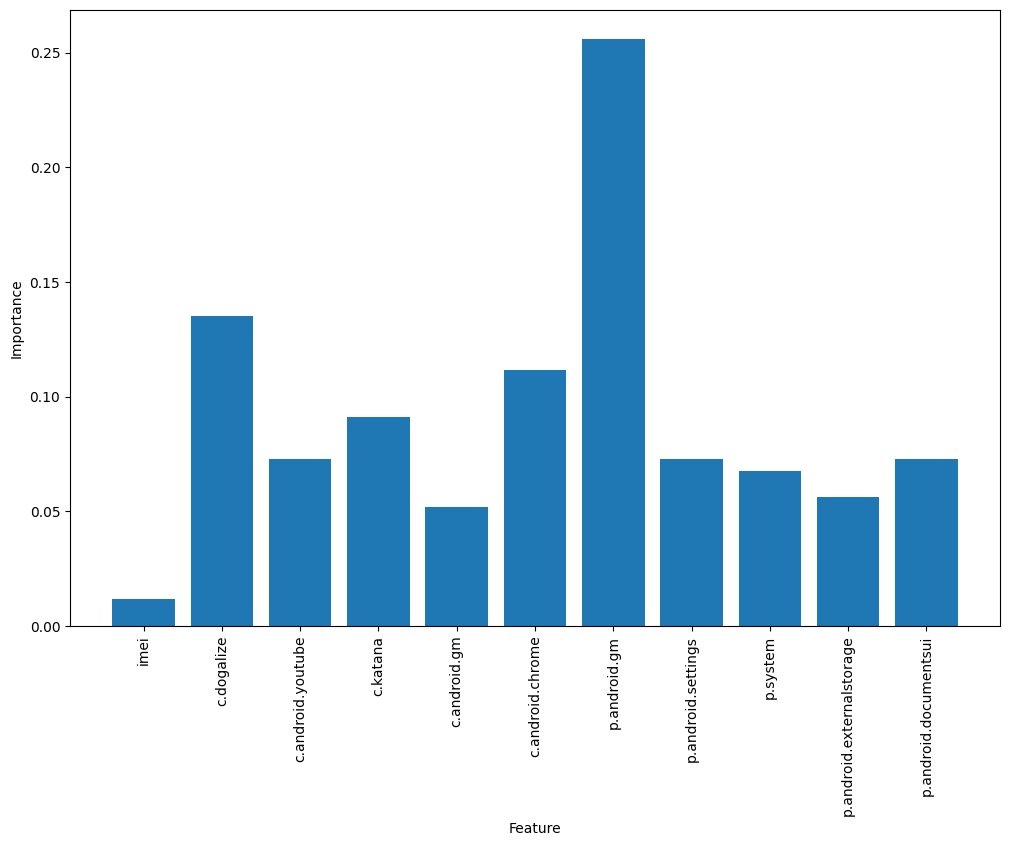

In [51]:
importances = rf_clf.feature_importances_
feature_names = X_train.columns


plt.figure(figsize=(12, 8))
plt.bar(range(len(importances)), importances, align="center")
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

3.2)E

 The Random Forest Classifier and K Nearest Neighbors performed equally well in terms of accuracy (0.919) and precision (0.924), but RFC showed a slightly higher recall (0.947 vs. 0.923). The ID3 model achieved lower performance overall, with an accuracy of 0.865, precision of 0.884, and recall of 0.902.

In [52]:
print(f"ID3 \taccuracy:{id3_accuracy_test:.3f}\tprecision:{id3_precision:.3f}\trecall:{id3_recall:.3f}")
print(f"RFC \taccuracy:{rf_accuracy:.3f}\tprecision:{rf_precision:.3f}\trecall:{rf_recall:.3f}")
print(f"KNN \taccuracy:{rf_accuracy:.3f}\tprecision:{rf_precision:.3f}\trecall:{knn_recall:.3f}")

ID3 	accuracy:0.865	precision:0.884	recall:0.902
RFC 	accuracy:0.919	precision:0.924	recall:0.947
KNN 	accuracy:0.919	precision:0.924	recall:0.923
